In [1]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
import torch
from collections import Counter
import transformers
from transformers import pipeline
from datasets import load_dataset
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments
from transformers import Trainer
import math
from torch.utils.data import DataLoader
from transformers import default_data_collator
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import preprocessing
import pickle
import pandas as pd
import os
import re

/home/laurinemeier/anaconda3/envs/swerick/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
model_checkpoint = "KBLab/bert-base-swedish-cased"
tokenizer =preprocessing.create_tokenizer(model_checkpoint)

In [4]:
model_kb = preprocessing.create_model_MLM(model_checkpoint)
model_kb=model_kb.to(device)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
with open("lm_dataset.pkl","rb") as f:
    lm_datasets= pickle.load(f)

In [6]:
with open("valid_dataset.pkl","rb") as f:
    valid_dataset= pickle.load(f)

valid_dataset

DatasetDict({
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 762794
    })
})

In [7]:
valid_dataset=valid_dataset.remove_columns(["word_ids","token_type_ids"])
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)
lm_dataset_bis = lm_datasets.remove_columns(["word_ids","token_type_ids"])

print(lm_dataset_bis["test"])
eval_dataset = preprocessing.create_deterministic_eval_dataset(lm_dataset_bis["test"],data_collator)
valid_dataset=preprocessing.create_deterministic_eval_dataset(valid_dataset["valid"],data_collator)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 800106
})


In [8]:
batch_size = 64
train_dataloader = preprocessing.create_dataloader(lm_dataset_bis["train"],batch_size,data_collator)
def to_device(batch):
    return {key: value.to(device) for key, value in batch.items()}

print("ok")
eval_dataloader = preprocessing.create_dataloader(eval_dataset,batch_size,default_data_collator)
valid_dataloader=preprocessing.create_dataloader(valid_dataset,batch_size,default_data_collator)

ok


In [9]:
from transformers import PreTrainedTokenizerFast

swerick_tokenizer= PreTrainedTokenizerFast(
    tokenizer_file="/home/laurinemeier/swerick/pretraining_from_scratch/tokenizer_swerick.json",
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]"
)

In [11]:
config = transformers.BertConfig.from_pretrained("pretraining_from_scratch/checkpoint-841424")
mosaicBert = AutoModelForMaskedLM.from_pretrained("pretraining_from_scratch/checkpoint-841424",config=config,trust_remote_code=True)

/home/laurinemeier/.cache/huggingface/modules/transformers_modules/checkpoint-841424/bert_layers.py:177: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(


In [15]:
pipe = pipeline(task="fill-mask", model=mosaicBert, tokenizer=swerick_tokenizer)
pipe("Hey [MASK]")

[{'score': 0.03553388640284538,
  'token': 18,
  'token_str': '.',
  'sequence': 'Hey.'},
 {'score': 0.030466275289654732,
  'token': 16,
  'token_str': ',',
  'sequence': 'Hey,'},
 {'score': 0.020780669525265694,
  'token': 373,
  'token_str': 'att',
  'sequence': 'Hey att'},
 {'score': 0.01568838395178318,
  'token': 75,
  'token_str': 'i',
  'sequence': 'Hey i'},
 {'score': 0.015056636184453964,
  'token': 387,
  'token_str': 'och',
  'sequence': 'Hey och'}]

In [7]:
model_hugging_face = AutoModelForMaskedLM.from_pretrained("finetuning_hugging_whitespace_bis-finetuned-imdb/checkpoint-858750")
model_hugging_face=model_hugging_face.to(device)

In [17]:
with open("valid_scratch.pkl","rb") as f :
    valid_data = pickle.load(f)

In [18]:
data_collector =preprocessing.data_collector_masking(tokenizer,0.15)
valid_data = valid_data.remove_columns(["word_ids","token_type_ids"])
valid_scratch_loader =preprocessing.create_deterministic_eval_dataset(valid_data["valid"],data_collator)
valid_scratch_loader =preprocessing.create_dataloader(valid_scratch_loader,64,default_data_collator)

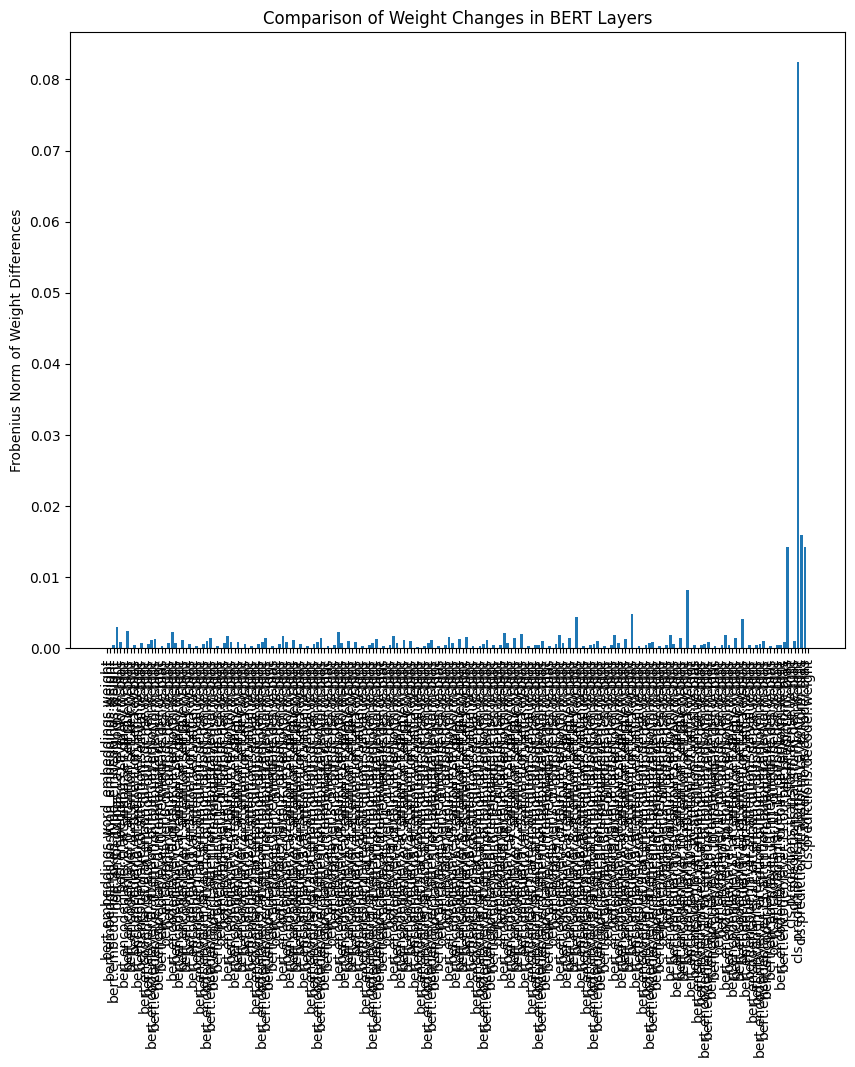

In [21]:
# Comparaison of weights for different models
import matplotlib.pyplot as plt
import numpy as np

def get_model_weights(model):
    weights = {}
    for name, param in model.named_parameters():
        weights[name] = param.detach().cpu().numpy()
    return weights


weights_kb = get_model_weights(model_kb)
weights_finetuned = get_model_weights(model_hugging_face)

weight_diffs = {}
for key in weights_kb.keys():
    weight_diffs[key] = weights_finetuned[key] - weights_kb[key]
    # if (np.linalg.norm(weight_diffs[key],2)) > 0.01 :
    #     print(key)
    #     print(np.linalg.norm(weight_diffs[key],2))
    #     print(weight_diffs[key].size)
    #     print( np.linalg.norm(weight_diffs[key])/weight_diffs[key].size)
    

weight_diffs["cls.predictions.decoder.bias"] = model_hugging_face.cls.predictions.decoder.bias.detach().cpu().numpy() - model_kb.cls.predictions.decoder.bias.detach().cpu().numpy()
weight_diffs["cls.predictions.decoder.weight"] = model_hugging_face.cls.predictions.decoder.weight.detach().cpu().numpy() - model_kb.cls.predictions.decoder.weight.detach().cpu().numpy()
norms = [(np.linalg.norm(weight_diffs[key])/weight_diffs[key].size) for key in weight_diffs.keys()]

plt.figure(figsize=(10, 8))
plt.bar(range(len(norms)), norms, tick_label=list(weight_diffs.keys()))
plt.xticks(rotation=90)
plt.ylabel('Frobenius Norm of Weight Differences')
plt.title('Comparison of Weight Changes in BERT Layers')
plt.show()  

['checkpoint-343500', 'checkpoint-400750', 'checkpoint-458000', 'checkpoint-515250', 'checkpoint-572500', 'checkpoint-629750', 'checkpoint-687000', 'checkpoint-744250', 'checkpoint-801500', 'checkpoint-858750', 'checkpoint-916000', 'checkpoint-973250', 'checkpoint-1030500', 'checkpoint-1087750', 'checkpoint-1145000', 'checkpoint-1202250', 'checkpoint-1259500', 'checkpoint-1316750', 'checkpoint-1374000', 'checkpoint-1431250', 'checkpoint-1488500', 'checkpoint-1545750', 'checkpoint-1603000', 'checkpoint-1660250', 'checkpoint-1717500', 'checkpoint-1774750', 'checkpoint-1832000', 'checkpoint-1889250', 'checkpoint-1946500', 'checkpoint-2003750', 'checkpoint-2061000', 'checkpoint-2118250', 'checkpoint-2175500', 'checkpoint-2232750', 'checkpoint-2290000', 'checkpoint-2347250', 'checkpoint-2404500', 'checkpoint-2461750', 'checkpoint-2519000', 'checkpoint-2576250', 'checkpoint-2633500', 'checkpoint-2690750', 'checkpoint-2748000', 'checkpoint-2805250', 'checkpoint-2862500', 'checkpoint-2919750',

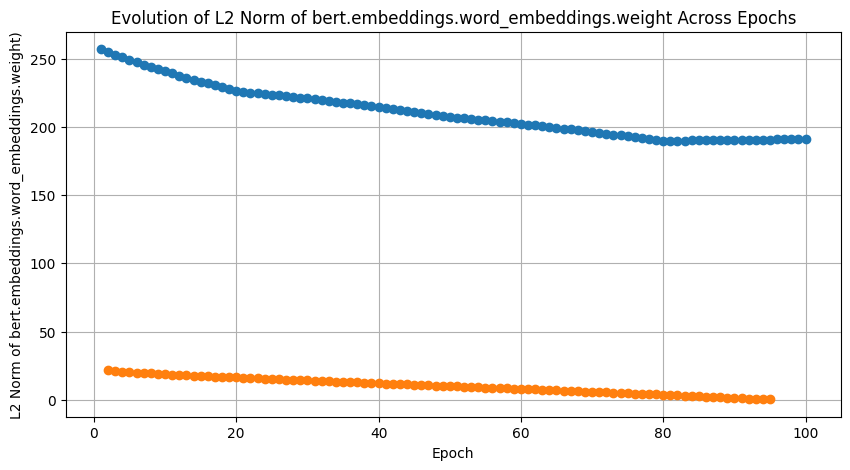

In [33]:
#Evolution of a specific layer through epochs
checkpoint_directory = 'finetuning/finetuning_hugging_whitespace-finetuned-imdb'
checkpoint_files = os.listdir(checkpoint_directory)

checkpoint_files.sort(key=lambda x: int(re.search(r'checkpoint-(\d+)', x).group(1)))
print(checkpoint_files)

bias_norms = []
drift=[]
bias_weight=model_kb.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
print(np.linalg.norm(bias_weight))

for checkpoint in checkpoint_files:
    model = AutoModelForMaskedLM.from_pretrained("finetuning/finetuning_hugging_whitespace-finetuned-imdb/" + checkpoint)
    ref_weight = bias_weight
    bias_weight = model.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
    norm = np.linalg.norm(bias_weight)
    bias_norms.append(norm)
    drift.append(np.linalg.norm(bias_weight - ref_weight))
    

epochs = list(range(1, len(bias_norms) + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs, bias_norms, marker='o')
plt.plot(epochs[1:95], drift[1:95], marker='o')
plt.xlabel('Epoch')
plt.ylabel('L2 Norm of bert.embeddings.word_embeddings.weight)')
plt.title('Evolution of L2 Norm of bert.embeddings.word_embeddings.weight Across Epochs')
plt.grid(True)
plt.show()

Study of Word Embedding

In [34]:
# Token present in the training dataset

token_frequencies = Counter()


for example in lm_datasets["train"]:
    token_frequencies.update(example['input_ids'])

NameError: name 'Counter' is not defined

In [ ]:
#Most frequent token

n = int(len(token_frequencies.keys())*0.8) 
most_common_tokens = token_frequencies.most_common(n)
most_common_ids, most_common_freqs = zip(*most_common_tokens)
most_common_ids_tensor = torch.tensor(most_common_ids)

print("Les IDs des tokens les plus fréquents et leurs fréquences :")
for token_id, freq in zip(most_common_ids, most_common_freqs):
    print(f"Token ID: {token_id}, Fréquence: {freq}")

In [ ]:
#change in embedding 
model_hugging_face = AutoModelForMaskedLM.from_pretrained("finetuning/finetuning_hugging_whitespace-finetuned-imdb/checkpoint-5725000")
model_hugging_face=model_hugging_face.to(device)
ref_weight = model_kb.bert.embeddings.word_embeddings.weight.detach()[most_common_ids_tensor]
bias_weight = model_hugging_face.bert.embeddings.word_embeddings.weight.detach()[most_common_ids_tensor]
embedding_changes = torch.norm(bias_weight - ref_weight, dim=1)

unk_index = tokenizer.convert_tokens_to_ids('[UNK]')
pad_index =  tokenizer.convert_tokens_to_ids('[PAD]')
print(pad_index)
print(embedding_changes[unk_index])
print(embedding_changes[pad_index])
values, top_indices = torch.topk(embedding_changes, 100)

# Convert indices to tokens
top_words = [tokenizer.convert_ids_to_tokens(idx.item()) for idx in top_indices]
print(values)
# Print the results
print("Top 25 words with the most changed embeddings vectors:")
for word in top_words:
    print(word)

In [ ]:
# Graph represent the most changed word embedding thorugh epochs

checkpoint_directory = 'finetuning/finetuning_hugging_whitespace-finetuned-imdb'
checkpoint_files = os.listdir(checkpoint_directory)

checkpoint_files.sort(key=lambda x: int(re.search(r'checkpoint-(\d+)', x).group(1)))
epoch_data = {}
word_color = {}
total_frequencies = {}
initial_embeddings = model_kb.bert.embeddings.word_embeddings.weight.detach()[most_common_ids_tensor]
colors = plt.cm.viridis(np.linspace(0, 1, 5))
# Training loop
epoch=4
for checkpoint in checkpoint_files:
    epoch +=1
    model = AutoModelForMaskedLM.from_pretrained("finetuning/finetuning_hugging_whitespace-finetuned-imdb/" + checkpoint)
    model=model.to(device)
    #initial_embeddings = embeddings
    embeddings = model.bert.embeddings.word_embeddings.weight.detach()[most_common_ids_tensor]

    embedding_changes = torch.norm(embeddings - initial_embeddings, dim=1)
    
    # Get the top 5 changes
    _, top_indices = torch.topk(embedding_changes, 1)
    top_words = [tokenizer.convert_ids_to_tokens(idx.item()) for idx in top_indices]
    top_changes = embedding_changes[top_indices].tolist()
    for word in top_words:
            if word not in word_color:
                word_color[word] = colors[len(word_color) % len(colors)]
            if word not in total_frequencies :
                total_frequencies[word] =1
            if word  in total_frequencies :
                total_frequencies[word] +=1
        
    # Store data
    epoch_data[epoch] = list(zip(top_words, top_changes))

# Plotting
fig, ax = plt.subplots(figsize=(10, 7))
already_labeled = set()
for epoch in epoch_data:
    words, changes = zip(*epoch_data[epoch])
    if words[0] not in already_labeled:
        ax.plot([epoch] * 1, changes, marker='o', linestyle='', markersize=10,color=word_color[words[0]],label=words[0])
        already_labeled.add(words[0])
    else : 
        ax.plot([epoch] * 1, changes, marker='o', linestyle='', markersize=10,color=word_color[words[0]])

ax.set_xlabel('Epoch')
ax.set_ylabel('Change in Norm of Embeddings')
ax.set_title('Most changed word embedding by Epoch')
ax.legend()
plt.show()

bert.encoder.layer.0.attention.self.key.bias
156.04853399695173
156.04853399695173
bert.encoder.layer.1.attention.self.key.bias
176.24164794763524
176.24164794763524
bert.encoder.layer.2.attention.self.key.bias
129.0638039506778
129.0638039506778
bert.encoder.layer.3.attention.self.key.bias
134.35950120285233
134.35950120285233
bert.encoder.layer.4.attention.self.key.bias
157.54792559899658
157.54792559899658
bert.encoder.layer.5.attention.self.key.bias
238.3091183882105
238.3091183882105
bert.encoder.layer.6.attention.self.key.bias
289.83717491075606
289.83717491075606
bert.encoder.layer.7.attention.self.key.bias
377.6107126423443
377.6107126423443
bert.encoder.layer.8.attention.self.key.bias
863.446555774214
863.446555774214
bert.encoder.layer.9.attention.self.key.bias
959.2074037080937
959.2074037080937
bert.encoder.layer.10.attention.self.key.bias
1544.9753869672948
1544.9753869672948
bert.encoder.layer.11.attention.self.key.bias
903.5166384536569
903.5166384536569
cls.predictions.

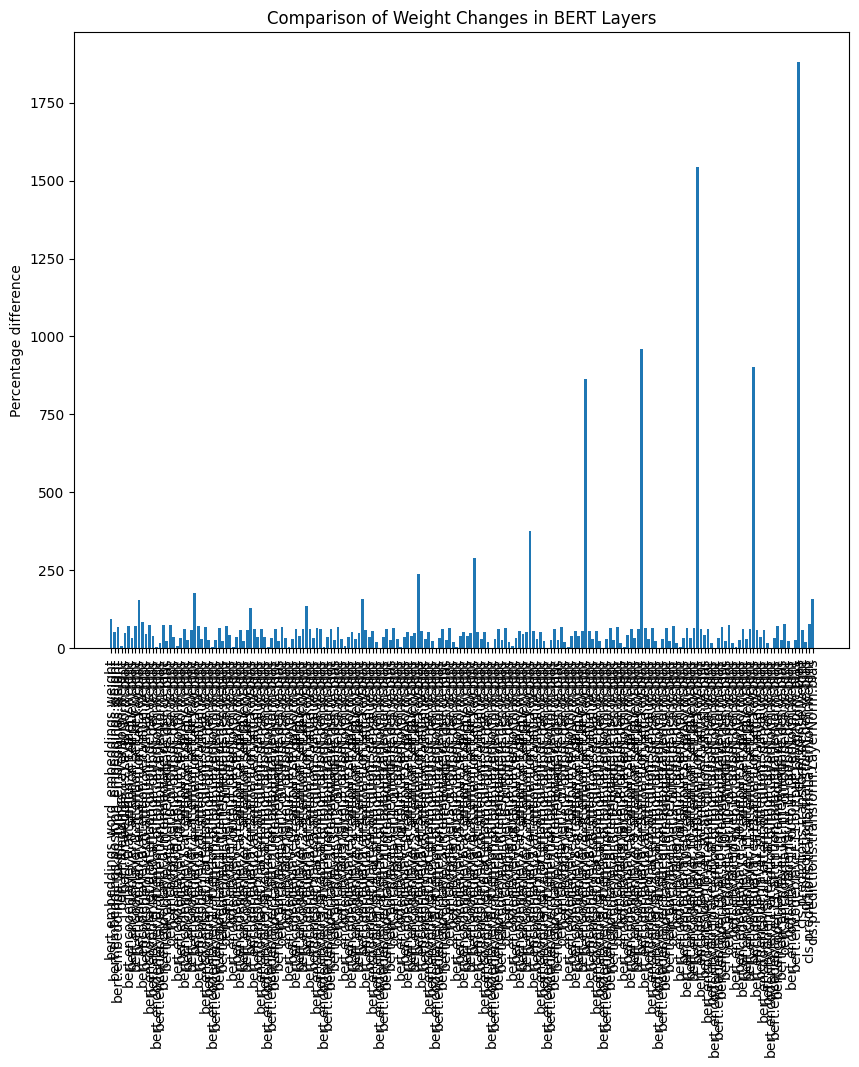

In [54]:
#Percentage difference between layers
def get_model_weight_bis(model):
    weights = {}
    for name, param in model.named_parameters():
        weights[name] = param.detach().cpu().numpy().flatten()
    return weights


weights_kb = get_model_weight_bis(model_kb)
weights_finetuned = get_model_weight_bis(model_hugging_face)
weight_diffs["cls.predictions.decoder.bias"] = model_hugging_face.cls.predictions.decoder.bias.detach().cpu().numpy().flatten() - model_kb.cls.predictions.decoder.bias.detach().cpu().numpy().flatten()
weight_diffs["cls.predictions.decoder.weight"] = model_hugging_face.cls.predictions.decoder.weight.detach().cpu().numpy().flatten() - model_kb.cls.predictions.decoder.weight.detach().cpu().numpy().flatten()

# Initialize lists to store all percent differences
percent_differences = {}
epsilon = 1e-6 
# Calculate percent differences for each corresponding weight
for key in weights_kb:
    if key in weights_finetuned:  # Ensure the key exists in both models
        weight_kb = weights_kb[key]
        weight_ft = weights_finetuned[key]
        # Compute percent difference only where the initial weights are not zero to avoid division by zero
        percent_diff = 100*np.linalg.norm(weight_ft - weight_kb) / np.linalg.norm(weight_kb)
        #percent_diff = np.abs(weight_ft-weight_kb)
        
        percent_differences[key]=np.mean(percent_diff) # Append differences to the list
        if percent_differences[key] >500 :
            print(key)
            print(percent_diff)
            print(percent_differences[key])
        

# Plotting the histogram of percent differences
percent = [percent_differences[key] for key in percent_differences.keys()]


plt.figure(figsize=(10, 8))
plt.bar(range(len(percent)), percent, tick_label=list(percent_differences.keys()))
plt.xticks(rotation=90)
plt.ylabel('Percentage difference')
plt.title('Comparison of Weight Changes in BERT Layers')
plt.show() 

In [16]:
from datasets import Dataset
with open("valid_dataset.pkl","rb") as f:
    valid_dataset= pickle.load(f)
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)
valid_dataset=valid_dataset.remove_columns(["word_ids","token_type_ids"])
valid_dataset=preprocessing.create_deterministic_eval_dataset(Dataset.from_dict(valid_dataset["valid"][:10000]),data_collator)
valid_dataloader=preprocessing.create_dataloader(valid_dataset,64,default_data_collator)

Map: 100%|██████████| 10000/10000 [00:02<00:00, 4542.47 examples/s]


Layer-wise cosine similarities: [0.69037983 0.77607106 0.75952145 0.73875937 0.72133521 0.70755435
 0.69524314 0.68212668 0.66864349 0.66499877 0.65326354 0.63028012
 0.5503447 ]


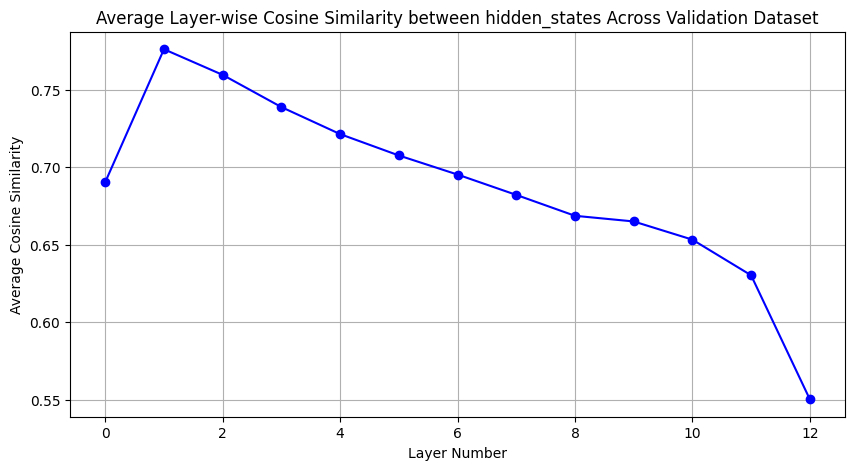

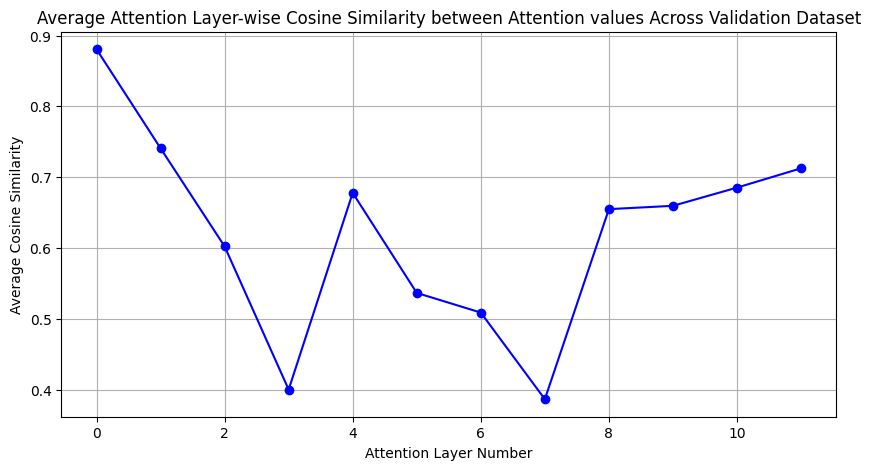

In [18]:
# Cosine similarity between layers
from datasets import Dataset
import torch
import numpy as np


def extract_activations(model, inputs):
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states
    return hidden_states

def extract_and_compare_activations(model_pre, model_post, dataloader):
    similarities_hidden_states = []
    similarities_attention=[]
    for batch in dataloader:
        batch = {k: batch[k].to(device) for k in batch.keys()}
        with torch.no_grad():
            pre_output= model_pre(**batch, output_hidden_states=True, output_attentions=True)
            pre_activations = pre_output.hidden_states
            pre_attention = pre_output.attentions
            post_output = model_post(**batch, output_hidden_states=True,output_attentions=True)
            post_activations = post_output.hidden_states
            post_attention = post_output.attentions
        
        example_similarities_hidden_states = [cosine_similarity(pre_activations[layer], post_activations[layer]) for layer in range(len(pre_activations))]
        example_similarities_attention = [cosine_similarity(pre_attention[layer], post_attention[layer]) for layer in range(len(pre_attention))]
        del pre_output
        del post_output
        del pre_attention
        del post_attention
        similarities_hidden_states.append(example_similarities_hidden_states)
        similarities_attention.append(example_similarities_attention)
    
    mean_similarities_hidden_states = np.mean(similarities_hidden_states, axis=0)
    mean_similarities_attention = np.mean(similarities_attention, axis=0)
    return mean_similarities_hidden_states,mean_similarities_attention

def cosine_similarity(tensor1, tensor2):
    # Ensure tensors are flattened (1D) to compute vector cosine similarity
    tensor1_flat = tensor1.view(-1)
    tensor2_flat = tensor2.view(-1)
    cos_sim = torch.nn.functional.cosine_similarity(tensor1_flat.unsqueeze(0), tensor2_flat.unsqueeze(0))
    return cos_sim.item()

def compare_activations(pre_ft_activations, post_ft_activations):
    differences = {}
    for layer in range(len(pre_ft_activations)):
        sim = cosine_similarity(pre_ft_activations[layer], post_ft_activations[layer])
        differences[layer] = sim
    return differences


def plot_results(mean_similarities,x_label='Layer Number',y_label='Average Cosine Similarity',title='Average Layer-wise Cosine Similarity between hidden_states Across Validation Dataset'):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(mean_similarities)), mean_similarities, marker='o', linestyle='-', color='b')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

mean_similarities_hidden_states,mean_similarities_attention = extract_and_compare_activations(model_kb, model_hugging_face, valid_dataloader)
print("Layer-wise cosine similarities:", mean_similarities_hidden_states)


plot_results(mean_similarities_hidden_states)
plot_results(mean_similarities_attention,'Attention Layer Number',title='Average Attention Layer-wise Cosine Similarity between Attention values Across Validation Dataset')



In [79]:
len(pre_attention[0][0][0])

128

In [83]:
for name,param in model_hugging_face.named_parameters():
    print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc